# 01 Data Quality and Universe Overview

This notebook showcases data-loading and disclosure diagnostics:
- Load and validate disclosures and prices
- Inspect cross-person holdings coverage
- Visualize latest portfolio composition for a selected case study


In [1]:
from pathlib import Path
import sys

import matplotlib.pyplot as plt
import pandas as pd

ROOT = Path.cwd()
if not (ROOT / "src").exists() and (ROOT.parent / "src").exists():
    ROOT = ROOT.parent

sys.path.insert(0, str(ROOT / "src"))

from portfolio_bl.config import load_config
from portfolio_bl.data.disclosures import load_disclosures_csv, latest_portfolio_for_aliases
from portfolio_bl.data.prices import load_prices_csv

plt.style.use("seaborn-v0_8-whitegrid")
pd.options.display.float_format = "{:.4f}".format


In [2]:
cfg = load_config(ROOT / "configs/case_studies.yaml")
disclosures = load_disclosures_csv(cfg.disclosures_path)
prices = load_prices_csv(cfg.prices_path)

print(f"Disclosures rows: {len(disclosures):,}")
print(f"Price rows: {len(prices):,}")
print(f"Price tickers: {prices['ticker'].nunique()}")
disclosures.head()


Disclosures rows: 12
Price rows: 108
Price tickers: 6


,person,as_of_date,ticker,value_usd,source,person_norm
0,Donald Trump,2025-03-31,AAPL,50,SYNTHETIC_EXAMPLE,donald trump
1,Donald Trump,2025-03-31,JPM,90,SYNTHETIC_EXAMPLE,donald trump
2,Donald Trump,2025-03-31,MSFT,40,SYNTHETIC_EXAMPLE,donald trump
3,Donald Trump,2025-03-31,XOM,80,SYNTHETIC_EXAMPLE,donald trump
4,Nancy Pelosi,2025-03-31,AAPL,70,SYNTHETIC_EXAMPLE,nancy pelosi


In [3]:
latest_dates = disclosures.groupby("person_norm", as_index=False)["as_of_date"].max()
latest_rows = disclosures.merge(latest_dates, on=["person_norm", "as_of_date"], how="inner")

coverage = (
    latest_rows.groupby("person_norm")
    .agg(
        n_holdings=("ticker", "nunique"),
        total_value=("value_usd", "sum"),
    )
    .sort_values("total_value", ascending=False)
)
coverage


,n_holdings,total_value
person_norm,,
warren buffett,4,400
nancy pelosi,4,280
donald trump,4,260


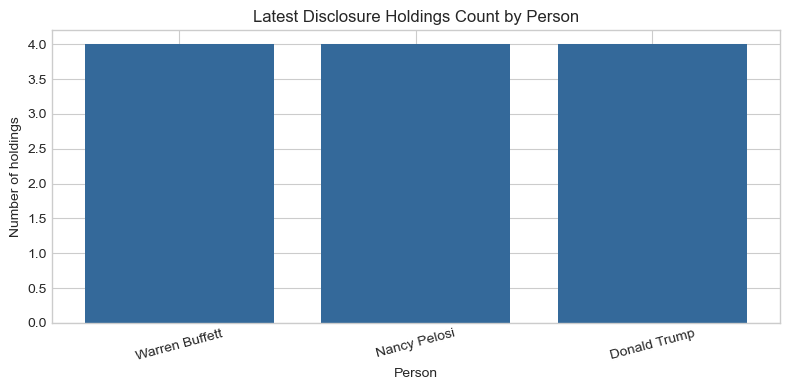

In [4]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(coverage.index.str.title(), coverage["n_holdings"], color="#34699A")
ax.set_title("Latest Disclosure Holdings Count by Person")
ax.set_xlabel("Person")
ax.set_ylabel("Number of holdings")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


In [5]:
person_key = "buffett"
case_cfg = cfg.case_studies[person_key]
latest_portfolio, as_of_date = latest_portfolio_for_aliases(disclosures, case_cfg.disclosure_aliases)

latest_portfolio = latest_portfolio.sort_values("weight", ascending=False)
print(f"Latest portfolio for {case_cfg.person_label} ({as_of_date.date()}):")
latest_portfolio


Latest portfolio for Warren Buffett (2025-03-31):


,ticker,value_usd,weight
0,AAPL,180,0.4500
2,MSFT,110,0.2750
3,XOM,70,0.1750
1,JPM,40,0.1000


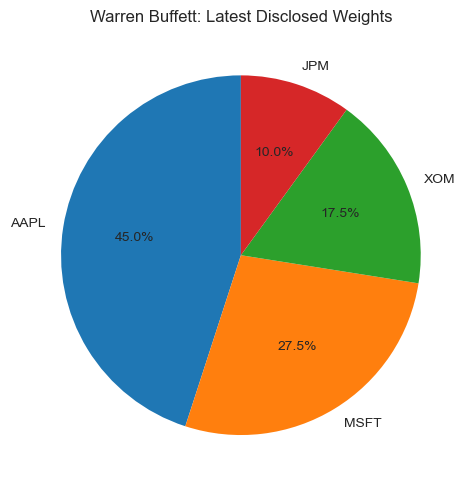

In [6]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.pie(
    latest_portfolio["weight"],
    labels=latest_portfolio["ticker"],
    autopct="%1.1f%%",
    startangle=90,
)
ax.set_title(f"{case_cfg.person_label}: Latest Disclosed Weights")
plt.tight_layout()
plt.show()


## Notes

- This uses synthetic starter data included in the repo.
- Swap in real disclosures/prices under `data/raw/` to produce real case-study results.
